In [3]:
%reload_kedro
train_data = catalog.load("train_data")
test_data = catalog.load("eval_data")
best_estimators = catalog.load("best_estimators")
serie_id = catalog.load("params:series_level.columns")
serie_target = catalog.load("params:serie_target")
date_col = catalog.load("params:serie_period")

2022-02-07 22:24:43,592 - kedro.framework.hooks.manager - INFO - Registered hooks from 1 installed plugin(s): kedro-mlflow-0.7.6
2022-02-07 22:24:43,687 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-02-07 22:24:43,744 - kedro.config.config - INFO - Config from path `/home/matheus/projects/time_series_kedro/conf/local` will override the following existing top-level config keys: fr_horizon, initial, models, n_jobs, sampling
2022-02-07 22:24:43,746 - root - INFO - ** Kedro project time_series_kedro
2022-02-07 22:24:43,747 - root - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`
2022-02-07 22:24:43,764 - root - INFO - Registered line magic `run_viz`
2022-02-07 22:24:43,765 - root - INFO - Registered line magic `reload_kedro_mlflow`
2022-02-07 22:24:43,766 - kedro.io.data_catalog - INFO - Loading data from `train_data` (CSVDataSet)...
2022-02-07 22:24:43,863 - kedro.io.data_catalog - INFO -

In [4]:
train_data.group.value_counts()

4    36784
2    35112
3    33440
0     5016
Name: group, dtype: int64

In [2]:
train_data = train_data[(train_data.store_nbr==27) & (train_data.family=='HOME AND KITCHEN II')]
y_true = test_data[(test_data.store_nbr==27) & (test_data.family=='HOME AND KITCHEN II')].set_index("date")["sales"]

<AxesSubplot:xlabel='date'>

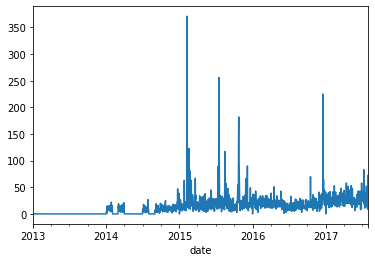

In [3]:
ts =train_data.set_index("date")["sales"]
ts.plot()

<AxesSubplot:xlabel='date'>

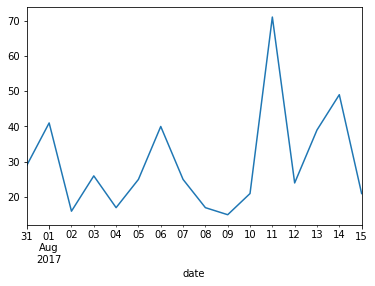

In [4]:
y_true.plot()

In [1]:

from typing import Any, Dict, List, Union
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_log_error
import time_series_kedro.extras.models as models
import pandas as pd
from tqdm import tqdm

def _test_model(
    data: pd.DataFrame,
    test_data: pd.DataFrame,
    serie_id: Union[str, List],
    serie_target: str,
    date_col: str,
    score: str
    ):
    """
    This node evaluate the best estimator in test.
    Args:
        data: DataFrame with train time series.
        test_data: DataFrame with test time series.
        best_estimators: DataFrame with best estimators for each serie.
        serie_id: Column or list of columns that identify series.
        serie_data: DataFrame with time series.
        serie_target: Target column name.
        date_col: Period column name.
        score: used metric
    Returns:
        Metrics in test
    """
    group = data.group.values[0]
     #pd.Series([True for _ in range(test_data.shape[0])], index=test_data.index)
    if isinstance(serie_id, list):
        serie_points = True
        for id_col in serie_id:
            idx = data[id_col].values[0]
            serie_points = (serie_points) & (test_data[id_col] == idx)
    else:
        idx = data[serie_id].values[0]
        serie_points = test_data[serie_id] == idx
    y_true = test_data[serie_points].set_index(date_col)[serie_target]
    ts = data.set_index(date_col)[serie_target]

    estimator = eval(f"models.{data.best_estimator.iloc[0]}")
    return ts, data.best_estimator.iloc[0], y_true
    estimator = estimator.fit(ts)
    y_pred = estimator.predict(y_true.shape[0])
    #y_pred[y_pred < 0] = 0
    
    if score == "rmse":
        metric = np.sqrt(mean_squared_error(y_true, y_pred))
    if score == "mape":
        metric = mean_absolute_percentage_error(y_true + 1, y_pred + 1)
    if score == "rmsle":
        metric = np.sqrt(mean_squared_log_error(y_true + 1, y_pred + 1))
    return pd.Series({"group": group,  "metric": metric})

/home/matheus/.local/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [2]:
train_data = catalog.load("train_data")
test_data = catalog.load("eval_data")
best_estimators = catalog.load("best_estimators")
serie_id = catalog.load("params:series_level.columns")
serie_target = catalog.load("params:serie_target")
date_col = catalog.load("params:serie_period")
train_data = pd.merge(train_data, best_estimators, on=serie_id)
data = train_data[(train_data.store_nbr==27) & (train_data.family=='HOME AND KITCHEN II')]
ts, estimator, y_true= _test_model(data, test_data,serie_id,serie_target, date_col,score="rmsle")
estimator = eval(f"models.{estimator}")
estimator.fit(ts)
estimator.predict(16)

2022-02-07 22:11:58,193 - kedro.io.data_catalog - INFO - Loading data from `train_data` (CSVDataSet)...
2022-02-07 22:11:58,260 - kedro.io.data_catalog - INFO - Loading data from `eval_data` (CSVDataSet)...
2022-02-07 22:11:58,265 - kedro.io.data_catalog - INFO - Loading data from `best_estimators` (CSVDataSet)...
2022-02-07 22:11:58,268 - kedro.io.data_catalog - INFO - Loading data from `params:series_level.columns` (MemoryDataSet)...
2022-02-07 22:11:58,269 - kedro.io.data_catalog - INFO - Loading data from `params:serie_target` (MemoryDataSet)...
2022-02-07 22:11:58,270 - kedro.io.data_catalog - INFO - Loading data from `params:serie_period` (MemoryDataSet)...


2017-07-31    29.373385
2017-08-01    29.071070
2017-08-02    29.162105
2017-08-03    28.860295
2017-08-04    28.951832
2017-08-05    28.650523
2017-08-06    28.742561
2017-08-07    28.441750
2017-08-08    28.534286
2017-08-09    28.233972
2017-08-10    28.327003
2017-08-11    28.027184
2017-08-12    28.120708
2017-08-13    27.821381
2017-08-14    27.915396
2017-08-15    27.616558
Freq: D, dtype: float64

In [ ]:

estimator.fit(ts)
estimator.predict(16)

Attempt: nan
Attempt: nan
Attempt: nan


AttributeError: 'ETSModel' object has no attribute 'forecast'

In [11]:
estimator._model.llf

nan

In [36]:
import time_series_kedro.extras.models as models
estimator = models.ExponentialSmoothing(seasonal_periods=15, trend='mul')
estimator.fit(ts)
y_pred = estimator.predict(y_true.shape[0])
y_pred[y_pred < 0] = 0
y_pred

2017-07-31    33.502340
2017-08-01    33.666900
2017-08-02    33.832245
2017-08-03    33.998378
2017-08-04    34.165303
2017-08-05    34.333025
2017-08-06    34.501547
2017-08-07    34.670872
2017-08-08    34.841006
2017-08-09    35.011950
2017-08-10    35.183710
2017-08-11    35.356289
2017-08-12    35.529691
2017-08-13    35.703921
2017-08-14    35.878981
2017-08-15    36.054876
Freq: D, Name: simulation, dtype: float64

In [40]:
estimator.predict(y_true.shape[0])

2017-07-31    33.502340
2017-08-01    33.666900
2017-08-02    33.832245
2017-08-03    33.998378
2017-08-04    34.165303
2017-08-05    34.333025
2017-08-06    34.501547
2017-08-07    34.670872
2017-08-08    34.841006
2017-08-09    35.011950
2017-08-10    35.183710
2017-08-11    35.356289
2017-08-12    35.529691
2017-08-13    35.703921
2017-08-14    35.878981
2017-08-15    36.054876
Freq: D, Name: simulation, dtype: float64